0.3443967313628906
[1024.9194, 789.726, 758.9849999999999, 918.048, 1011.6359999999999, 1130.9904000000001, 925.0926, 905.2685999999999, 1087.6284, 1161.9053999999999, 1102.9848, 866.3213999999999, 877.4766000000001, 1056.2178, 1129.8768, 909.2382, 708.3696, 733.9362000000001, 893.562, 934.8768000000001, 736.8821999999999, 551.565, 518.3843999999999, 679.9386, 721.5491999999999] [935.5493999999999, 782.8938, 780.3240000000001, 935.6376, 1019.7503999999999, 1208.8667999999998, 979.5342, 1038.9666, 1254.9479999999999, 1329.027, 1277.2967999999998, 988.8204, 1054.9542, 1363.0692000000001, 1412.5500000000002, 1532.0675999999999, 1116.6365999999998, 1151.838, 1537.1645999999998, 1536.012, 1585.5521999999999, 1222.7633999999998, 1265.5128000000002, 1781.5710000000001, 1818.6444000000001]
3.7902997566848134e-05
[431.7996, 356.87940000000003, 325.2864, 384.975, 433.212, 478.9374, 406.30260000000004, 382.314, 449.7342, 488.17560000000003, 417.46799999999996, 339.9918, 334.5264, 388.195200000000

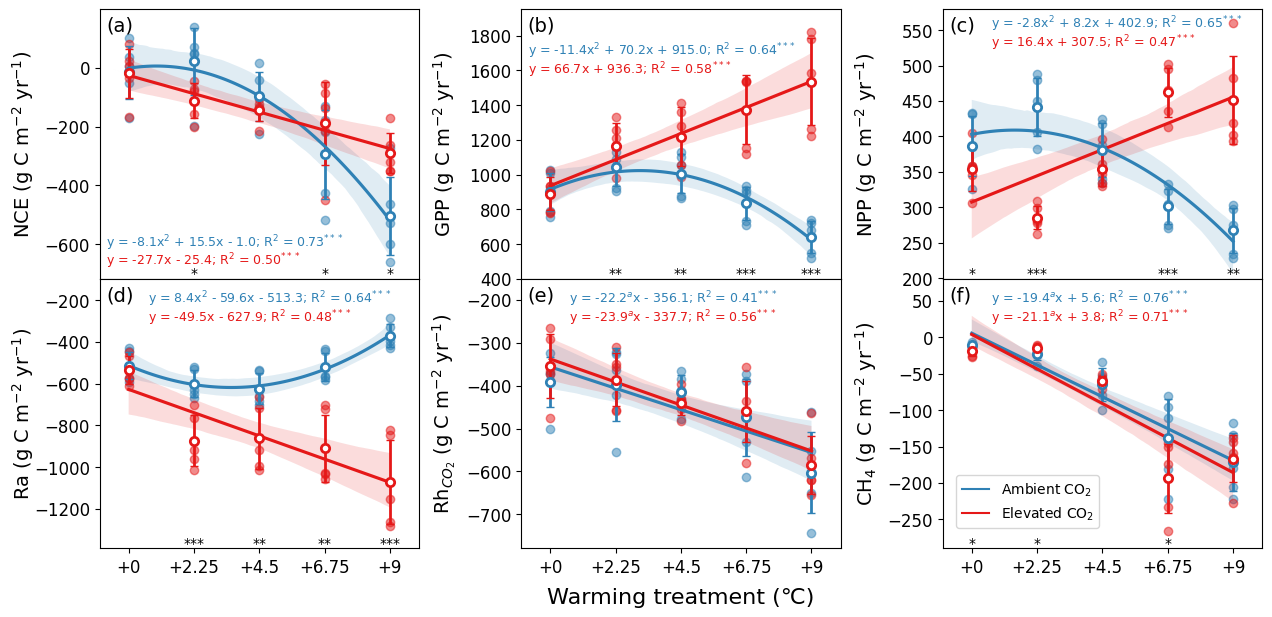

In [1]:
# figure-1,the results of carbon fluxes: NCE; GPP; NPP; Ra; Rh; CH4


# read data
import pandas as pd
import numpy as np

df_data_mlm  = pd.read_excel("/Users/jianzhou/MyDocs/1_works/1_proj_SPRUCE/1_SPRUCE_DA/4_summary_data_code_paper/test_output/2_mod_results/results_MLM/1_2_1_data_MLM/2_df_res_mlm_yrDel_nomean.xlsx")
# choose column names 
var_names_in = ["plot",        'warming', 'year',
                "gpp_Tree",    "gpp_Shrub",    "gpp_Sphagnum", 
                "npp_Tree",    "npp_Shrub",    "npp_Sphagnum", 
                "ra_Tree",     "ra_Shrub",     "ra_Sphagnum",    
                "rh", 
                "del_C_plant_Tree", "del_C_plant_Shrub", "del_C_plant_Sphagnum", 
                "del_C_litter",     "del_C_soil", "ch4"]
df_data = df_data_mlm[var_names_in]
df_data = df_data[df_data["year"] > 2016]

# plot number for different treatments
i_warmPlots  = [1, 9, 5, 2, 7]
i_warmEleCO2 = [8, 4, 0, 6, 3]
# -----------------------------------------------------------

import statsmodels.api as sm
import statsmodels.formula.api as smf

def cal_reg_diff(x1, y1, x2, y2): # justify if there is significant difference between two groups data
    # create two group datasets
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    group = np.array([1]*len(x1) + [2]*len(x2))  # 1: group one; 2: group two

    # create a model include interactive object
    data = {'y': y, 'x': x, 'group': group}
    model = smf.ols('y ~ x + group + x * C(group)', data=data).fit()

    pvalue_diff_slope     = model.pvalues['x:C(group)[T.2]']
    pvalue_diff_intercept = model.pvalues['C(group)[T.2]']

    if pvalue_diff_slope < 0.05:
        res_ab_slope = ("a", "b")
    else:
        res_ab_slope = ("a", "a")

    if pvalue_diff_intercept < 0.05:
        res_ab_intercept = ("a", "b")
    else:
        res_ab_intercept = ("a", "a")

    return res_ab_slope, res_ab_intercept


def compare_linear_quadratic(x,y):
    # add constant
    X1 = sm.add_constant(x)  # linear
    X2 = sm.add_constant(np.column_stack((x, x**2)))  # quadratic

    # create model
    model_linear = sm.OLS(y, X1).fit()
    model_quadratic = sm.OLS(y, X2).fit()

    # print(f"linear: AIC = {model_linear.aic}, BIC = {model_linear.bic}")
    # print(f"R-squared: {model_linear.rsquared}")
    # print(f"coef_slope: {model_linear.params[1]}, interpt: {model_linear.params[0]}")

    # print(f"quadratic: AIC = {model_quadratic.aic}, BIC = {model_quadratic.bic}")
    # print(f"R-squared: {model_quadratic.rsquared}")
    # print(f"coef_x2: {model_quadratic.params[-1]}, coef_x: {model_quadratic.params[1]}, interpt: {model_quadratic.params[0]}")

    # print(f"delta AIC (quadratic - linear): {model_quadratic.aic - model_linear.aic}")

    info_linear    = {"R2"       : model_linear.rsquared,
                      "pvalue"   : model_linear.f_pvalue, 
                      "slope"    : model_linear.params[1], 
                      "intercept": model_linear.params[0]} 
    info_quadratic = {"R2"       : model_quadratic.rsquared,
                      "pvalue"   : model_quadratic.f_pvalue, 
                      "x2"       : model_quadratic.params[-1], 
                      "x"        : model_quadratic.params[1],
                      "intercept": model_quadratic.params[0]}

    info_AIC_BIC = {
        "AIC_linear": model_linear.aic,
        "AIC_quadratic": model_quadratic.aic,
        "BIC_linear": model_linear.bic,
        "BIC_quadratic": model_quadratic.bic,
        "diff_AIC": model_linear.aic - model_quadratic.aic,
        "diff_BIC": model_linear.bic - model_quadratic.bic
    }

    return info_linear, info_quadratic, info_AIC_BIC

def check_pvalue(pvalue):
    if   pvalue < 0.001: 
        mark_p = "***"; line_style = "-"
    elif pvalue < 0.01: 
        mark_p = "**"; line_style = "-"
    elif pvalue < 0.05: 
        mark_p = "*"; line_style = "-"
    else: 
        mark_p = ""; line_style = "--"
    return mark_p, line_style


def check_negative(b, c=None):
    if c is None:
        if b < 0:
            ret_str = "y = {:.1f}$^{}$x - {:.1f}; R$^2$ = {:.2f}"
        else:
            ret_str = "y = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}"
    else:
        if b < 0:
            if c < 0:
                ret_str = "y = {:.1f}x$^2$ - {:.1f}x - {:.1f}; R$^2$ = {:.2f}"
            else:
                ret_str = "y = {:.1f}x$^2$ - {:.1f}x + {:.1f}; R$^2$ = {:.2f}"
        else:
            if c < 0:
                ret_str = "y = {:.1f}x$^2$ + {:.1f}x - {:.1f}; R$^2$ = {:.2f}"
            else:
                ret_str = "y = {:.1f}x$^2$ + {:.1f}x + {:.1f}; R$^2$ = {:.2f}"
    return ret_str


# start to plot
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import linregress
import matplotlib.ticker as ticker
from scipy import stats
from scipy.stats import mannwhitneyu

# import matplotlib as mpl
%matplotlib inline
# mpl.rcParams['text.usetex'] = False

def to_int(x, pos):
    return '{:.0f}'.format(x)


nrow = 2; ncol = 3

fig, axes = plt.subplots(nrow, ncol, figsize=(15,7)) 

ls_subtitle = [["(a)", "(b)", "(c)"],
               ["(d)", "(e)", "(f)"]]

ls_ylim = [[(-719, 199), (400, 1950), (199, 579) ],
           [(-1390, -99), (-780, -151), (-290, 80)]]

ls_pos  = [[(0.02, 0.1, 0.03), (0.02, 0.81, 0.74), (0.15, 0.91, 0.84) ],
           [(0.15, 0.89, 0.82), (0.15, 0.89, 0.82), (0.15, 0.89, 0.82)]]

x_bar = [0, 2.25, 4.5, 6.75, 9]
custom_x_ticks  = [0,      2.25,    4.5,    6.75,    9]  # x stick
custom_x_labels = ['+0', '+2.25', '+4.5', '+6.75', '+9']  # x-axis label

ls_vars = ["nce", "gpp", "npp",  "ra", "rh", "ch4"]
idx_var = -1

for irow in range(nrow):
    for icol in range(ncol):
        ax = axes[irow, icol]
        idx_var += 1
        ivar = ls_vars[idx_var]
        # read data
        df_data_ivar = df_data[["plot", 'warming', 'year']]
        if ivar == "gpp":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["gpp_Tree"] + df_data["gpp_Shrub"] + df_data["gpp_Sphagnum"])
        elif ivar == "npp":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["npp_Tree"] + df_data["npp_Shrub"] + df_data["npp_Sphagnum"])
        elif ivar == "nce":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["gpp_Tree"] + df_data["gpp_Shrub"] + df_data["gpp_Sphagnum"] 
                                                       - (df_data["ra_Tree"] + df_data["ra_Shrub"] + df_data["ra_Sphagnum"]) 
                                                       - df_data["rh"] - df_data["ch4"])
        elif ivar == "ra":
            df_data_ivar = df_data_ivar.assign(dat_ivar = -(df_data["ra_Tree"] + df_data["ra_Shrub"] + df_data["ra_Sphagnum"]))
        elif ivar == "rh":
            df_data_ivar = df_data_ivar.assign(dat_ivar = -df_data["rh"])
        elif ivar == "ch4":
            df_data_ivar = df_data_ivar.assign(dat_ivar = -df_data["ch4"])
        
        # handle data
        x           = []
        y_aco2      = []
        y_eco2      = []
        y_mean_aco2 = []
        y_mean_eco2 = []
        y_std_aco2  = []
        y_std_eco2  = []
        
        for iwarm, ico2 in zip(i_warmPlots, i_warmEleCO2):
            x.extend(df_data_ivar[df_data_ivar["plot"]==ico2]["warming"])
            ls_dat_aco2 =(df_data_ivar[df_data_ivar["plot"]==iwarm]["dat_ivar"]).to_numpy().flatten().tolist()
            y_aco2.extend(ls_dat_aco2)
            y_mean_aco2.append(np.nanmean(np.array(ls_dat_aco2)))
            y_std_aco2.append(np.nanstd(np.array(ls_dat_aco2)))
            # -----------------------------------------------------------------
            ls_dat_eco2 =(df_data_ivar[df_data_ivar["plot"]==ico2]["dat_ivar"]).to_numpy().flatten().tolist()
            y_eco2.extend(ls_dat_eco2)
            y_mean_eco2.append(np.nanmean(np.array(ls_dat_eco2)))
            y_std_eco2.append(np.nanstd(np.array(ls_dat_eco2)))

            # check if there is significant difference between aCO2 and eCO2
            # t_stat, p_value = stats.ttest_ind(ls_dat_aco2, ls_dat_eco2)
            t_stat, p_value = stats.ttest_rel(ls_dat_aco2, ls_dat_eco2)
            # t_stat, p_value = wilcoxon(ls_dat_aco2, ls_dat_eco2)
            # stat, p_value = mannwhitneyu(ls_dat_aco2, ls_dat_eco2)
            # t_stat, p_value = stats.ttest_1samp(np.array(ls_dat_eco2) - np.array(ls_dat_aco2), 0)
            
            if   p_value < 0.001: txt_mark_p = "***"
            elif p_value < 0.01:  txt_mark_p = "**"
            elif p_value < 0.05:  txt_mark_p = "*"
            else: txt_mark_p = ""
            # print(p_value, txt_mark_p)
            ax.text(df_data_ivar[df_data_ivar["plot"]==ico2]["warming"].to_numpy().flatten()[0], ls_ylim[irow][icol][0] + 0.02*abs(ls_ylim[irow][icol][1]-ls_ylim[irow][icol][0]), 
                    txt_mark_p, ha="center", va="center", fontsize=10)
            
        if irow == 0 and icol == 1: print(y_aco2, y_eco2)
        if irow == 0 and icol == 2: print(y_aco2, y_eco2); print(y_mean_aco2, y_mean_eco2)
        if irow == 1 and icol == 2: print(y_aco2, y_eco2)
        ax.scatter(x,y_aco2,alpha=0.5,color="#2F81B5",zorder=1)
        ax.scatter(x,y_eco2,alpha=0.5,color="#E51818",zorder=1)
        ax.errorbar(x_bar, y_mean_aco2, yerr=[np.array(y_std_aco2), np.array(y_std_aco2)], fmt='none', ecolor='#2F81B5', capsize=3, linewidth=2,zorder=2)
        ax.errorbar(x_bar, y_mean_eco2, yerr=[np.array(y_std_eco2), np.array(y_std_eco2)], fmt='none', ecolor='#E51818', capsize=3, linewidth=2,zorder=2)
        ax.scatter(x_bar, y_mean_aco2, marker='o', color='white', edgecolors='#2F81B5', linewidth=2, zorder=3)
        ax.scatter(x_bar, y_mean_eco2, marker='o', color='white', edgecolors='#E51818', linewidth=2, zorder=3)

        # t_stat, p_value = stats.ttest_ind(y_aco2, y_eco2)
        # t_stat, p_value = stats.ttest_rel(y_aco2, y_eco2)
        # t_stat, p_value = mannwhitneyu(y_aco2, y_eco2)
        t_stat, p_value = stats.ttest_1samp(np.array(y_eco2) - np.array(y_aco2), 0)
        print(p_value)

        # linear and quadratic test
        info_linear_aco2, info_quadratic_aco2, info_diff_aco2 = compare_linear_quadratic(np.array(x), np.array(y_aco2))
        info_linear_eco2, info_quadratic_eco2, info_diff_eco2 = compare_linear_quadratic(np.array(x), np.array(y_eco2))

        # check if significant different
        if abs(info_diff_aco2["diff_AIC"]) < 4 and abs(info_diff_eco2["diff_AIC"]) < 4 :
            res_ab_slope, res_ab_intercept = cal_reg_diff(np.array(x), np.array(y_aco2), np.array(x), np.array(y_eco2))
        else:
            res_ab_slope, res_ab_intercept = ('\u200B', '\u200B'), ('\u200B', '\u200B')
        
        # linear or quadratic
        if abs(info_diff_aco2["diff_AIC"]) < 4:
            info_aco2 = info_linear_aco2; order_aco2 = 1
            mark_p, line_style = check_pvalue(info_aco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][1], 
                    # "y$^{}$ = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[0],info_aco2["slope"],res_ab_slope[0],info_aco2["intercept"],info_aco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_aco2["intercept"]).format(info_aco2["slope"],res_ab_slope[0],abs(info_aco2["intercept"]),info_aco2["R2"])+"$^{"+mark_p+"}$",
                    fontsize=9, transform=ax.transAxes, color="#2F81B5", va='bottom')
        else: 
            info_aco2 = info_quadratic_aco2; order_aco2 = 2
            mark_p, line_style = check_pvalue(info_aco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][1], 
                    # "y$^{}$ = {:.1f}x$^2$ + {:.1f}x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[0],info_aco2["x2"],info_aco2["x"],info_aco2["intercept"], info_aco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_aco2["x"], info_aco2["intercept"]).format(info_aco2["x2"],abs(info_aco2["x"]),abs(info_aco2["intercept"]), info_aco2["R2"])+"$^{"+mark_p+"}$", 
                    fontsize=9, transform=ax.transAxes, color="#2F81B5", va='bottom')

        
        sns.regplot(x=x, y=y_aco2, order=order_aco2,ax=ax, scatter_kws={'alpha': 0.7, 'color':"#00857B"},line_kws={"linestyle": line_style}, scatter=False, color="#2F81B5") #, color="#2F81B5",  label="Ambient CO$_2$")
        
        
        # print("eCO2 ---", ivar,"------abs--", abs(info_diff_eco2["diff_AIC"]))
        if abs(info_diff_eco2["diff_AIC"]) < 4:
            info_eco2 = info_linear_eco2; order_eco2 = 1
            mark_p, line_style = check_pvalue(info_eco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][2], 
                    # "y$^{}$ = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[1],info_eco2["slope"],res_ab_slope[1],info_eco2["intercept"],info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_eco2["intercept"]).format(info_eco2["slope"],res_ab_slope[1],abs(info_eco2["intercept"]),info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    fontsize=9, transform=ax.transAxes, color="#E51818", va='bottom')
            
        else: 
            info_eco2 = info_quadratic_eco2; order_eco2 = 2
            mark_p, line_style = check_pvalue(info_eco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][2], 
                    # "y$^{}$ = {:.1f}x$^2$ + {:.1f}x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[1],info_eco2["x2"],info_eco2["x"],info_eco2["intercept"], info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_eco2["x"],info_eco2["intercept"]).format(info_eco2["x2"],abs(info_eco2["x"]),abs(info_eco2["intercept"]), info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    fontsize=9, transform=ax.transAxes, color="#E51818", va='bottom')

            # ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][2], "y = {:.1f}x$^2$ + {:.1f}x - {:.1f}; R$^2$ = {:.2f}".format(coefficients[-1],coefficients[1],-coefficients[0],r_squared)+"$^{"+mark_p+"}$", fontsize=10, transform=ax.transAxes, color="#2F81B5", va='bottom')

        if info_eco2["pvalue"] < 0.001: mark_p = "***"; line_style = "-"
        elif info_eco2["pvalue"] < 0.01: mark_p = "**"; line_style = "-"
        elif info_eco2["pvalue"] < 0.05: mark_p = "*"; line_style = "-"
        else: mark_p = ""; line_style = "--"
        sns.regplot(x=x, y=y_eco2, order=order_eco2,ax=ax, scatter_kws={'alpha': 0.7, 'color':"#00857B"},line_kws={"linestyle": line_style},scatter=False, color="#E51818")

        ax.set_xticks(custom_x_ticks, custom_x_labels, fontsize=12)
        ax.tick_params(axis='x', labelsize=12)  # x-axis ticks font size
        ax.tick_params(axis='y', labelsize=12)  # y-axis ticks font size

        ax.text(0.02, 0.92, ls_subtitle[irow][icol], fontsize=14, transform=ax.transAxes)
        ax.set_xlim(-1, 10)
        ax.set_ylim(ls_ylim[irow][icol][0], ls_ylim[irow][icol][1])
        
        


import matplotlib.lines as mlines
# 创建图例句柄
blue_line = mlines.Line2D([], [], color='#2F81B5', linestyle = "-", label='Ambient CO$_2$')
green_line = mlines.Line2D([], [], color='#E51818', linestyle = "-", label='Elevated CO$_2$')

# 添加图例
ax.legend(bbox_to_anchor=(0.02, 0.05), loc='lower left', handles=[blue_line, green_line])
# ax.legend(loc='upper right', handles=[blue_line, green_line])



# axes[1,2].axis("off")

axes[0,0].text(-0.24, 0.5, "NCE (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,0].transAxes, fontsize=14)
axes[0,1].text(-0.24, 0.5, "GPP (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,1].transAxes, fontsize=14)
axes[0,2].text(-0.24, 0.5, "NPP (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,2].transAxes, fontsize=14)

axes[1,0].text(-0.24, 0.5, "Ra (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,0].transAxes, fontsize=14)
axes[1,1].text(-0.24, 0.5, "Rh$_{CO_2}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,1].transAxes, fontsize=14)
axes[1,2].text(-0.24, 0.5, "CH$_4$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,2].transAxes, fontsize=14)


ax.set_xticks(custom_x_ticks, custom_x_labels, fontsize=12)
axes[1,1].text(0.5, -0.18, "Warming treatment (℃)", fontsize=16, ha='center', va='center', transform=axes[1,1].transAxes)


plt.subplots_adjust(hspace=0, wspace=0.32)